In [1]:
import tensorflow as tf
import numpy as np
import datetime
import json
import gzip
import matplotlib.pyplot as plt
import re
import os
import shutil
from tqdm import tqdm_notebook

In [2]:
sess = None

In [3]:
def reset_tf(sess = None, log_device_placement = False):
    if sess:
        sess.close()
    tf.reset_default_graph()
    tf.set_random_seed(0)
    return tf.InteractiveSession(config = tf.ConfigProto(log_device_placement = log_device_placement))

def dump_statistics():
    total_parameters = 0
    for variable in tf.trainable_variables():
        # shape is an array of tf.Dimension
        shape = variable.get_shape()
        variable_parameters = 1
        for dim in shape:
            variable_parameters *= dim.value
        print('parameters for "%s": %d' % (variable.name, variable_parameters))
        total_parameters += variable_parameters
    print('total parameters: %d' % total_parameters)

In [4]:
class HyperParameters:
    learning_rate = 1e-3
    
    vocab_size = 30000
    num_targets = 2000
    
    dropout_rate = 0.1
    
    context_size = 81
    
    d_embedding_position = 32
    d_embedding_word = 128
    
    d_attention = 128
    d_attention_ff = 512
    
    attention_num_layers = 4

    dataset_batch_size = 512
    dataset_num_parallel_calls = 4
    dataset_prefetch_size = 4096
    dataset_shuffle_size = 4096
    
    gradient_clip_norm = 5.0

In [5]:
class EntityLinkingModel:
    def __init__(self, session, hp):
        self._session = session
        self._hp = hp
        
    def _parse_example(self, example_proto):
        parsed = tf.parse_single_example(example_proto, features = {
            'page_id': tf.FixedLenFeature([1], tf.int64),
            'target_id': tf.FixedLenFeature([1], tf.int64),
            'context_word_ids': tf.FixedLenFeature([self._hp.context_size], tf.int64),
            'link_mask': tf.FixedLenFeature([self._hp.context_size], tf.int64) })
        
#         # apply random crop
#         offset = tf.random_uniform(
#             [],
#             maxval = self._hp.input_context_size - self._hp.context_size,
#             dtype = tf.int32)
#
#         # apply croppings
#         context_word_ids = parsed['context_word_ids']
#         context_word_ids = context_word_ids[offset:offset + self._hp.context_size]
#         link_mask = parsed['link_mask']
#         link_mask = link_mask[offset:offset + self._hp.context_size]

        context_word_ids = parsed['context_word_ids']
        link_mask = parsed['link_mask']
        
        return (parsed['target_id'], context_word_ids, link_mask)

    def _build_data_pipeline(self):
        with tf.variable_scope('dataset'):
            # placeholders
            self._dataset_filenames = tf.placeholder(
                tf.string,
                shape = [None],
                name = 'dataset_filenames')
            self._dataset_limit = tf.placeholder_with_default(
                tf.constant(-1, tf.int64),
                shape = [],
                name = 'dataset_limit')
            self._dataset_shuffle_size = tf.placeholder_with_default(
                tf.constant(self._hp.dataset_batch_size, tf.int64),
                shape = [],
                name = 'dataset_shuffle_size')
            self._dataset_batch_size = tf.placeholder_with_default(
                tf.constant(self._hp.dataset_batch_size, tf.int64),
                shape = [],
                name = 'dataset_batch_size')
            self._dataset_prefetch_size = tf.placeholder_with_default(
                tf.constant(self._hp.dataset_prefetch_size, tf.int64),
                shape = [],
                name = 'dataset_prefetch_size')

            # build dataset
            dataset = tf.data.TFRecordDataset(
                tf.random_shuffle(self._dataset_filenames),
                compression_type='GZIP')
            dataset = dataset.take(self._dataset_limit)
            dataset = dataset.map(
                self._parse_example,
                num_parallel_calls = self._hp.dataset_num_parallel_calls)
            dataset = dataset.shuffle(self._dataset_shuffle_size)
            dataset = dataset.prefetch(self._dataset_prefetch_size)
            dataset = dataset.batch(self._dataset_batch_size)

            # build iterator
            self._dataset_iterator = dataset.make_initializable_iterator()
            (target_labels, context_word_ids, link_mask) = self._dataset_iterator.get_next()
            target_labels = tf.squeeze(target_labels, axis = -1)

            # give key tensors names
            self._context_word_ids = tf.identity(context_word_ids, 'context_word_ids')
            self._target_labels = tf.identity(target_labels, 'target_labels')
            self._link_mask = tf.identity(link_mask, 'link_mask')

            # minibatch size
            self._minibatch_size = tf.shape(self._context_word_ids)[0]
            self._minibatch_size = tf.identity(self._minibatch_size, 'minibatch_size')
            
            # positions
            p = tf.range(self._hp.context_size, dtype = tf.int64)
            p = tf.tile(p, [self._minibatch_size])
            p = tf.reshape(
                p,
                [self._minibatch_size, self._hp.context_size],
                name = 'context_positions')
            self._context_positions = p
            
    def _attention_self(self, layer):
        with tf.variable_scope('self'):
            # variables
            kernels = tf.get_variable(
                'kernels',
                [2, self._hp.d_attention, self._hp.d_attention])
            
            # compute weights
            k0 = tf.tensordot(layer, kernels[0], axes = 1) # [batch_size, context_size, d_attention]
            k0.set_shape([None, self._hp.context_size, self._hp.d_attention])
            k1 = tf.tensordot(layer, kernels[1], axes = 1) # [batch_size, context_size, d_attention]
            k1.set_shape([None, self._hp.context_size, self._hp.d_attention])
            k1 = tf.transpose(k1, perm = [0, 2, 1])        # [batch_size, d_attention, context_size]
            w = tf.matmul(k0, k1)                          # [batch_size, context_size, context_size]
            mask = tf.diag([-1e20] * self._hp.context_size)
            mask = tf.expand_dims(mask, axis = 0)          # [1, context_size, context_size]
            w += mask
            w *= self._attention_scaling_factor
            w = tf.nn.softmax(w)
            
            # apply weights
            layer += tf.matmul(w, layer)
            
#             mask1 = tf.fill([self._hp.context_size, self._hp.context_size], -1e20)
#             mask2 = mask1
#             mask1 = tf.matrix_band_part(mask1, 0, -1)
#             mask2 = tf.matrix_band_part(mask2, -1, 0)
#             mask1 = tf.expand_dims(mask1, axis = 0)        # [1, context_size, context_size]
#             mask2 = tf.expand_dims(mask2, axis = 0)        # [1, context_size, context_size]
#             w1 = w + mask1
#             w2 = w + mask2
# #             w1 *= self._attention_scaling_factor
# #             w2 *= self._attention_scaling_factor
#             w1 = tf.nn.softmax(w1)
#             w2 = tf.nn.softmax(w2)
#            
#             # apply weights
#             layer = layer + tf.matmul(w1, layer) + tf.matmul(w2, layer)
            
            # batch norm
            layer = tf.layers.batch_normalization(
                layer,
                training = self._training)

            # dropout
            layer = tf.layers.dropout(
                layer,
                rate = self._hp.dropout_rate,
                training = self._training)
            
            return layer
    
    def _attention_output(self, layer):
        with tf.variable_scope('output'):
            # variables
            kernel = tf.get_variable(
                'kernel',
                [self._hp.d_attention, self._hp.d_attention])
            query = tf.get_variable(
                'query',
                [self._hp.d_attention, 1])
            
            # compute weights
            k = tf.tensordot(layer, kernel, axes = 1) # [batch_size, context_size, d_attention]
            k.set_shape([None, self._hp.context_size, self._hp.d_attention])
            w = tf.tensordot(k, query, axes = 1)      # [batch_size, context_size, 1]
            w.set_shape([None, self._hp.context_size, 1])
            w *= self._attention_scaling_factor
            mask = (1.0 - tf.cast(self._link_mask, tf.float32)) * -1e20 # [batch_size, context_size]
            mask = tf.expand_dims(mask, axis = -1)    # [batch_size, context_size, 1]
            w += mask
            w = tf.nn.softmax(w, dim = 1)
            
            # apply weights
            layer *= w
            layer = tf.reduce_sum(layer, axis = -2)   # [batch_size, d_attention]
            
            return layer
            
#     def _attention_self(self, layer):
#         with tf.variable_scope('self'):
#             # variables
#             inner_kernel = tf.get_variable(
#                 'inner_kernel',
#                 [2, self._hp.d_attention, self._hp.d_attention])
#             inner_bias = tf.get_variable(
#                 'inner_bias',
#                 [1, 1, 1, self._hp.d_attention])
#             outer_kernel = tf.get_variable(
#                 'outer_kernel',
#                 [self._hp.d_attention, 1])
#
#             # compute weights
#             w0 = tf.tensordot(layer, inner_kernel[0], axes = 1)
#             w0.set_shape([None, self._hp.context_size, self._hp.d_attention])
#             w1 = tf.tensordot(layer, inner_kernel[1], axes = 1)
#             w1.set_shape([None, self._hp.context_size, self._hp.d_attention])
#             w0 = tf.expand_dims(w0, axis = -2)
#             w1 = tf.expand_dims(w1, axis = -3)
#             w = tf.tanh(w0 + w1 + inner_bias)
#             w = tf.tensordot(w, outer_kernel, axes = 1)
#             w.set_shape([None, self._hp.context_size, self._hp.context_size, 1])
#             w = tf.nn.softmax(w, dim = 2)
#
#             # apply weights
#             layer = tf.reshape(layer, [-1, 1, self._hp.context_size, self._hp.d_attention])
#             layer *= w
#             layer = tf.reduce_sum(layer, axis = -2)
#
#             # batch norm
#             layer = tf.layers.batch_normalization(layer, training = self._training)
#
#             # dropout
#             layer = tf.layers.dropout(
#                 layer, 
#                 rate = self._hp.dropout_rate, 
#                 training = self._training)
#
#             return layer
#
#     def _attention_output(self, layer):
#         with tf.variable_scope('output'):
#             # variables
#             inner_kernel = tf.get_variable(
#                 'inner_kernel',
#                 [self._hp.d_attention, self._hp.d_attention])
#             inner_bias = tf.get_variable(
#                 'inner_bias',
#                 [1, 1, self._hp.d_attention])
#             outer_kernel = tf.get_variable(
#                 'outer_kernel',
#                 [self._hp.d_attention, 1])
#            
#             # compute weights
#             w = tf.tensordot(layer, inner_kernel, axes = 1)
#             w.set_shape([None, self._hp.context_size, self._hp.d_attention])
#             w += inner_bias
#             w = tf.tanh(w)
#             w = tf.tensordot(w, outer_kernel, axes = 1)
#             w.set_shape([None, self._hp.context_size, 1])
#            
#             # apply link mask
#             link_mask_bias = (1.0 - tf.cast(self._link_mask, tf.float32)) * -1e20
#             link_mask_bias = tf.reshape(link_mask_bias, [-1, self._hp.context_size, 1])
#             w += link_mask_bias
#            
#             # softmax
#             w = tf.nn.softmax(w, dim = 1)
#            
#             # apply weights
#             layer *= w
#             layer = tf.reduce_sum(layer, axis = -2)
#            
#             return layer

    def _attention_feed_forward(self, layer):
        with tf.variable_scope('ff'):
            # hidden layer
            layer = tf.layers.dense(
                layer,
                self._hp.d_attention_ff,
                activation = tf.nn.relu,
                name = 'fc1')
            
            # output
            layer = tf.layers.dense(
                layer,
                self._hp.d_attention,
                name = 'fc2')
            
            # batch norm
            layer = tf.layers.batch_normalization(
                layer,
                training = self._training)
            
            # dropout
            layer = tf.layers.dropout(
                layer, 
                rate = self._hp.dropout_rate, 
                training = self._training)
        
            return layer
            
    def _build_model(self):
        with tf.variable_scope('model'):
            # placeholder: training flag
            self._training = tf.placeholder(tf.bool, name = 'training')
            
            # embed context words
            word_embeddings = tf.get_variable(
                'word_embeddings', 
                [self._hp.vocab_size, self._hp.d_embedding_word])
            context_words_embedded = tf.nn.embedding_lookup(
                word_embeddings,
                self._context_word_ids)

            # embed context positions
            position_embeddings = tf.get_variable(
                'position_embeddings',
                [self._hp.context_size, self._hp.d_embedding_position],
                dtype=tf.float32)
            context_positions_embedded = tf.nn.embedding_lookup(
                position_embeddings,
                self._context_positions)

            # build full context vector (concat embeddings)
            context_full = tf.concat(
                [context_words_embedded, context_positions_embedded], 
                axis=-1)
            
            # build attention layers
            with tf.variable_scope('attention'):
                # scaling factor
                self._attention_scaling_factor = tf.get_variable(
                    'scaling_factor',
                    shape = [],
                    initializer = tf.constant_initializer([1.0 / np.sqrt(self._hp.d_attention)]))
                
                # build input vector
                context_attention = tf.layers.dense(
                    context_full,
                    self._hp.d_attention,
                    activation=tf.nn.relu,
                    name='input')
                context_attention = tf.layers.batch_normalization(
                    context_attention,
                    training=self._training,
                    name='input')
                context_attention = tf.layers.dropout(
                    context_attention,
                    rate=self._hp.dropout_rate,
                    training=self._training)
                
                layer = context_attention
                for i in range(self._hp.attention_num_layers):
                    with tf.variable_scope('layer_%d' % i):
                        layer = self._attention_self(layer)
#                         layer = self._attention_feed_forward(layer)
                    
                layer = self._attention_output(layer)
            
            # build final softmax layer
            self._output_logits = tf.layers.dense(
                layer,
                self._hp.num_targets,
                name = 'softmax')

    def _build_training_model(self):
        with tf.variable_scope('train'):
            losses = tf.nn.sparse_softmax_cross_entropy_with_logits(
                labels = self._target_labels,
                logits = self._output_logits)
            
            self._total_loss = tf.reduce_sum(losses, name = 'total_loss')
            self._mean_loss = tf.reduce_mean(losses, name = 'mean_loss')
            
            # N.B., tf.nn.softmax here is unnecessary?
            output_probs = tf.nn.softmax(self._output_logits)
            output_labels = tf.argmax(output_probs, axis=-1)
            correct_labels = tf.cast(
                tf.equal(output_labels, self._target_labels), 
                tf.int32)
            self._output_labels = tf.identity(output_labels, name = 'output_labels')
            self._num_correct_labels = tf.reduce_sum(correct_labels, name = 'num_correct_labels')
            
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.control_dependencies(update_ops):
                self._global_step = tf.Variable(0, name='global_step', trainable=False)
                self._optimizer = tf.train.AdamOptimizer(learning_rate=self._hp.learning_rate)
                
                # gradient clipping
                gradients, variables = zip(*self._optimizer.compute_gradients(self._mean_loss))
                gradients, _ = tf.clip_by_global_norm(
                    gradients, 
                    self._hp.gradient_clip_norm)
                
                self._train_op = self._optimizer.apply_gradients(
                    zip(gradients, variables),
                    global_step = self._global_step)
#                 self._train_op = self._optimizer.minimize(
#                     self._mean_loss,
#                     global_step=self._global_step)

    
    def build_model(self):
        self._build_data_pipeline()
        self._build_model()
        self._build_training_model()

    def process(self,
                dataset_filenames,
                dataset_limit = -1,
                header = 'results',
                train = False,
                log_file = None):
        # initialize dataset to files
        self._session.run(self._dataset_iterator.initializer, feed_dict={
            self._dataset_filenames: dataset_filenames,
            self._dataset_limit: dataset_limit })

        cum_loss = 0
        cum_num_examples = 0
        cum_correct_examples = 0
        
        start = datetime.datetime.now()
        progress = tqdm_notebook(leave = False, desc = header)

        while True:
            # process a minibatch
            try:
                (_,
                 curr_total_loss, 
                 curr_minibatch_size,
                 curr_num_correct_labels) = self._session.run(
                    (self._train_op if train else (),
                     self._total_loss,
                     self._minibatch_size,
                     self._num_correct_labels),
                    feed_dict = { self._training: train })
            except tf.errors.OutOfRangeError:
                break

            # update stats/progress
            cum_loss += curr_total_loss
            cum_num_examples += curr_minibatch_size
            cum_correct_examples += curr_num_correct_labels
            progress.update(curr_minibatch_size)

        progress.close()
        finish = datetime.datetime.now()

        # print/log output
        message = '%s: time=%s, step=%d, loss=%g, accuracy=%g' % (
            header,
            finish - start,
            tf.train.global_step(sess, self._global_step),
            cum_loss / cum_num_examples,
            cum_correct_examples / cum_num_examples)
        print(message)
        if log_file:
            print(message, file=log_file)
            log_file.flush()

In [6]:
sess = reset_tf(sess)

model = EntityLinkingModel(sess, HyperParameters())
model.build_model()
dump_statistics()

parameters for "model/word_embeddings:0": 3840000
parameters for "model/position_embeddings:0": 2592
parameters for "model/attention/scaling_factor:0": 1
parameters for "model/attention/input/kernel:0": 20480
parameters for "model/attention/input/bias:0": 128
parameters for "model/attention/input/gamma:0": 128
parameters for "model/attention/input/beta:0": 128
parameters for "model/attention/layer_0/self/kernels:0": 32768
parameters for "model/attention/layer_0/self/batch_normalization/gamma:0": 128
parameters for "model/attention/layer_0/self/batch_normalization/beta:0": 128
parameters for "model/attention/layer_1/self/kernels:0": 32768
parameters for "model/attention/layer_1/self/batch_normalization/gamma:0": 128
parameters for "model/attention/layer_1/self/batch_normalization/beta:0": 128
parameters for "model/attention/layer_2/self/kernels:0": 32768
parameters for "model/attention/layer_2/self/batch_normalization/gamma:0": 128
parameters for "model/attention/layer_2/self/batch_norm

In [7]:
sess.run(tf.global_variables_initializer())

In [8]:
def list_files(path):
    return sorted([os.path.join(path, file) for file in os.listdir(path)])

train_set = list_files('../data/simplewiki/simplewiki-20171103.el_softmax_3.train')
dev_set = list_files('../data/simplewiki/simplewiki-20171103.el_softmax_3.dev')
test_set = list_files('../data/simplewiki/simplewiki-20171103.el_softmax_3.test')

In [9]:
with open('../logs/simplewiki/mediawiki_el_softmax_3.log', 'wt') as f:
    for i in range(10):
        model.process(
            train_set,
            header = 'train %d' % i,
            train = True,
            log_file = f)
        model.process(
            dev_set,
            header = 'dev %d' % i,
            train = False,
            log_file = f)

HBox(children=(IntProgress(value=1, bar_style='info', description='train 0', max=1), HTML(value='')))

train 0: time=0:01:23.209245, step=971, loss=0.703767, accuracy=0.884498


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 0', max=1), HTML(value='')))

dev 0: time=0:00:01.104951, step=971, loss=0.201264, accuracy=0.95705


HBox(children=(IntProgress(value=1, bar_style='info', description='train 1', max=1), HTML(value='')))

train 1: time=0:01:22.770077, step=1942, loss=0.170871, accuracy=0.961664


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 1', max=1), HTML(value='')))

dev 1: time=0:00:00.992128, step=1942, loss=0.170788, accuracy=0.96365


HBox(children=(IntProgress(value=1, bar_style='info', description='train 2', max=1), HTML(value='')))

train 2: time=0:01:22.776234, step=2913, loss=0.126333, accuracy=0.969252


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 2', max=1), HTML(value='')))

dev 2: time=0:00:00.980019, step=2913, loss=0.164789, accuracy=0.96495


HBox(children=(IntProgress(value=1, bar_style='info', description='train 3', max=1), HTML(value='')))

train 3: time=0:01:22.778541, step=3884, loss=0.0944217, accuracy=0.975681


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 3', max=1), HTML(value='')))

dev 3: time=0:00:00.983211, step=3884, loss=0.166011, accuracy=0.9679


HBox(children=(IntProgress(value=1, bar_style='info', description='train 4', max=1), HTML(value='')))

train 4: time=0:01:22.780519, step=4855, loss=0.0720634, accuracy=0.98036


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 4', max=1), HTML(value='')))

dev 4: time=0:00:00.995295, step=4855, loss=0.173113, accuracy=0.96765


HBox(children=(IntProgress(value=1, bar_style='info', description='train 5', max=1), HTML(value='')))

train 5: time=0:01:22.782666, step=5826, loss=0.0578688, accuracy=0.983766


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 5', max=1), HTML(value='')))

dev 5: time=0:00:00.978940, step=5826, loss=0.185273, accuracy=0.96765


HBox(children=(IntProgress(value=1, bar_style='info', description='train 6', max=1), HTML(value='')))

train 6: time=0:01:22.781438, step=6797, loss=0.0467018, accuracy=0.986749


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 6', max=1), HTML(value='')))

dev 6: time=0:00:00.998138, step=6797, loss=0.191404, accuracy=0.96775


HBox(children=(IntProgress(value=1, bar_style='info', description='train 7', max=1), HTML(value='')))

train 7: time=0:01:22.758028, step=7768, loss=0.037135, accuracy=0.989421


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 7', max=1), HTML(value='')))

dev 7: time=0:00:00.992936, step=7768, loss=0.175433, accuracy=0.96885


HBox(children=(IntProgress(value=1, bar_style='info', description='train 8', max=1), HTML(value='')))

train 8: time=0:01:22.703014, step=8739, loss=0.0313213, accuracy=0.991034


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 8', max=1), HTML(value='')))

dev 8: time=0:00:00.976656, step=8739, loss=0.201133, accuracy=0.9692


HBox(children=(IntProgress(value=1, bar_style='info', description='train 9', max=1), HTML(value='')))

train 9: time=0:01:22.688108, step=9710, loss=0.0255363, accuracy=0.992732


HBox(children=(IntProgress(value=1, bar_style='info', description='dev 9', max=1), HTML(value='')))

dev 9: time=0:00:00.978550, step=9710, loss=0.196996, accuracy=0.9686


In [10]:
def decode(i):
    words = [vocab[word_id] for word_id in context_word_ids[i]]
    print('TARGET: %s' % targets[target_labels[i]])
    print('OUTPUT: %s' % targets[output_labels[i]])
    for j, (word, weight) in enumerate(zip(words, weights[i])):
        print('%02d %-40s %g' % (j, word, weight))

In [10]:
def plot(i):
    plt.figure(figsize=(30, 5))
    plt.title('%s / %s' % (targets[target_labels[i]], targets[output_labels[i]]))
    plt.bar(np.arange(weights.shape[1]), weights[i].ravel())
    plt.xticks(np.arange(weights.shape[1]), [vocab[word_id] for word_id in context_word_ids[i]], rotation='vertical')
    plt.show()

In [11]:
sess.run(model._dataset_iterator.initializer, feed_dict={
    model._dataset_filenames: dev_set[:1],
    model._training: False })
target_labels, output_labels, context_word_ids, weights = sess.run(
    [model._target_labels, model._output_labels, model._context_word_ids, model._attention_weights],
    feed_dict = { model._training: False })

AttributeError: 'EntityLinkingModel' object has no attribute '_attention_weights'

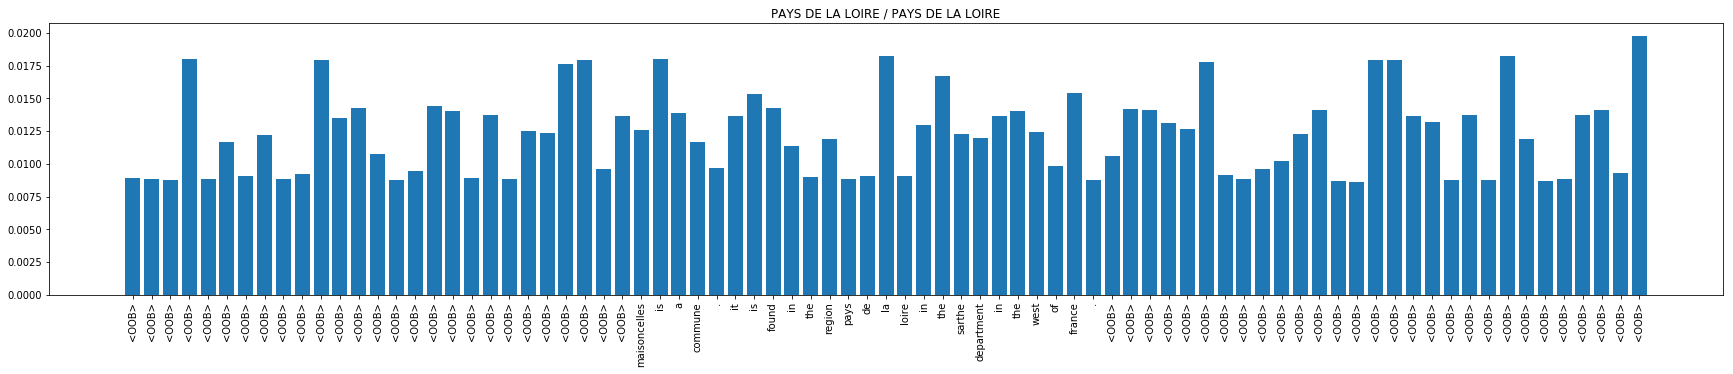

In [19]:
plot(3)

In [10]:
with open('../logs/simplewiki/mediawiki_el_softmax_3.log', 'rt') as f:
    lines = ''.join([l for l in f])

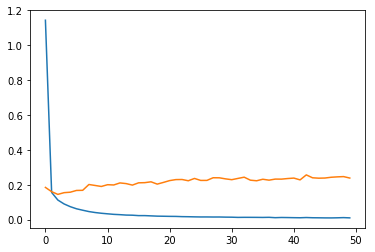

In [12]:
plt.plot([float(v) for v in re.findall(r'train.*loss=(\d+\.\d+)', lines)])
plt.plot([float(v) for v in re.findall(r'dev.*loss=(\d+\.\d+)', lines)])
plt.show()

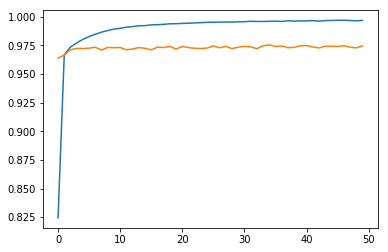

In [13]:
plt.plot([float(v) for v in re.findall(r'train.*accuracy=(\d+\.\d+)', lines)])
plt.plot([float(v) for v in re.findall(r'dev.*accuracy=(\d+\.\d+)', lines)])
plt.show()

In [18]:
shutil.rmtree(
    '../models/simplewiki/el_softmax_2',
    ignore_errors = True)
builder = tf.saved_model.builder.SavedModelBuilder(
    '../models/simplewiki/el_softmax_2')
builder.add_meta_graph_and_variables(
    sess,
    [tf.saved_model.tag_constants.TRAINING])
builder.add_meta_graph(
    [tf.saved_model.tag_constants.SERVING])
builder.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'../models/simplewiki/el_softmax_2/saved_model.pb'


b'../models/simplewiki/el_softmax_2/saved_model.pb'

# Error Analysis

In [5]:
sess = reset_tf(sess)

In [6]:
_ = tf.saved_model.loader.load(
    sess,
    [tf.saved_model.tag_constants.TRAINING],
    '../models/simplewiki/el_softmax_2')

INFO:tensorflow:Restoring parameters from b'../models/simplewiki/el_softmax_2/variables/variables'


In [8]:
dump_statistics()

parameters for "model/word_embeddings:0": 7680000
parameters for "model/position_embeddings:0": 1296
parameters for "model/attention_with_ff/input/kernel:0": 69632
parameters for "model/attention_with_ff/input/bias:0": 256
parameters for "model/attention_with_ff/input/gamma:0": 256
parameters for "model/attention_with_ff/input/beta:0": 256
parameters for "model/attention_with_ff/layer_0/attention/projection_weights:0": 65536
parameters for "model/attention_with_ff/layer_0/attention/output:0": 65536
parameters for "model/attention_with_ff/layer_0/attention/gamma:0": 256
parameters for "model/attention_with_ff/layer_0/attention/beta:0": 256
parameters for "model/attention_with_ff/layer_0/ff/fc1/kernel:0": 131072
parameters for "model/attention_with_ff/layer_0/ff/fc1/bias:0": 512
parameters for "model/attention_with_ff/layer_0/ff/fc2/kernel:0": 131072
parameters for "model/attention_with_ff/layer_0/ff/fc2/bias:0": 256
parameters for "model/attention_with_ff/layer_0/ff/gamma:0": 256
parame

In [10]:
dataset_iterator = tf.get_default_graph().get_operation_by_name('dataset/MakeIterator')
dataset_filenames = tf.get_default_graph().get_tensor_by_name('dataset/dataset_filenames:0')
training = tf.get_default_graph().get_tensor_by_name('model/training:0')
context_word_ids = tf.get_default_graph().get_tensor_by_name('dataset/context_word_ids:0')
link_mask = tf.get_default_graph().get_tensor_by_name('dataset/link_mask:0')
target_labels = tf.get_default_graph().get_tensor_by_name('dataset/target_labels:0')
output_labels = tf.get_default_graph().get_tensor_by_name('train/ArgMax:0')

In [11]:
with open('../data/simplewiki/simplewiki-20171103.el_softmax_3.vocab.txt', 'rt') as f:
    vocab = [w.strip() for w in f]

In [12]:
with open('../data/simplewiki/simplewiki-20171103.el_softmax_3.targets.txt', 'rt') as f:
    targets = [t.strip() for t in f]

In [13]:
def compute_negative_examples(filenames, limit = None):
    # initialize dataset iterator
    sess.run(dataset_iterator, feed_dict = {
        dataset_filenames: filenames,
        training: False })
    
    examples = []
    
    while True:
        # compute minibatch
        try:
            (curr_context_word_ids, curr_target_labels, curr_output_labels, curr_link_mask) = sess.run(
                (context_word_ids, target_labels, output_labels, link_mask),
                feed_dict = { training: False })
        except tf.errors.OutOfRangeError:
                break

        # loop through examples
        for c, t, o, l in zip(curr_context_word_ids, curr_target_labels, curr_output_labels, curr_link_mask):
            # skip accurate inferences
            if t == o:
                continue
                
            # stop if limit reached
            if limit and len(examples) >= limit:
                break
            
            # decode context
            words = []
            link_words = []
            for word_id, link_mask_flag in zip(c, l):
                word = vocab[word_id]
                if link_mask_flag:
                    words.append('_%s_' % word)
                    link_words.append(word)
                else:
                    words.append(word)

            # decode example
            examples.append([
                targets[t], # target label
                targets[o], # output label
                ' '.join(link_words), # link
                ' '.join(words) ]) # context
    
    return examples

In [14]:
examples = compute_negative_examples([
    '../data/simplewiki/simplewiki-20171103.el_softmax_3.dev/examples.0000000000.tfrecords.gz',
    '../data/simplewiki/simplewiki-20171103.el_softmax_3.dev/examples.0000010000.tfrecords.gz'])

In [16]:
examples[0]

['GAME SHOW',
 'GAME',
 'game',
 '<OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> <OOB> alan willis thicke ( born alan willis <UNK> ; march 1 , 1947 – december 13 , 2016 ) was a canadian actor , songwriter , and _game_ and talk show host . he was known for his role as jason <UNK> , the father on the abc television series growing pains . he was the father of singer robin thicke . thicke died at his home in']

In [36]:
import csv
with open('/tmp/errors.csv', 'wt') as f:
    writer = csv.writer(f)
    writer.writerow(['target', 'output', 'link', 'context'])
    for example in examples:
        writer.writerow(example)

In [38]:
x = tf.reshape(tf.range(16), [4,4])

In [39]:
tf.matrix_band_part(x, 0, -1).eval()

array([[ 0,  1,  2,  3],
       [ 0,  5,  6,  7],
       [ 0,  0, 10, 11],
       [ 0,  0,  0, 15]], dtype=int32)

In [40]:
tf.matrix_band_part(x, -1, 0).eval()

array([[ 0,  0,  0,  0],
       [ 4,  5,  0,  0],
       [ 8,  9, 10,  0],
       [12, 13, 14, 15]], dtype=int32)

In [ ]:
# with open('../logs/simplewiki/mediawiki_el_softmax_1.multihead.log.old', 'wt') as f:
#     print(lines)

In [ ]:
# with open('../logs/simplewiki/mediawiki_el_softmax_1.multihead.log', 'rt') as f:
#     lines = '\n'.join([l for l in f])
    
# plt.plot([float(v) for v in re.findall(r'train.*loss=(\d+\.\d+)', lines)], label='train')
# plt.plot([float(v) for v in re.findall(r'dev.*loss=(\d+\.\d+)', lines)], label='dev')
# plt.title('loss')
# plt.legend()
# plt.show()
# plt.plot([float(v) for v in re.findall(r'train.*accuracy=(\d+\.\d+)', lines)], label='train')
# plt.plot([float(v) for v in re.findall(r'dev.*accuracy=(\d+\.\d+)', lines)], label='dev')
# plt.title('accuracy')
# plt.legend()
# plt.show()